Objective:
Develop a Deep Q-Network (DQN) agent that can learn to play the Snake game by interacting with the environment. The agent should learn optimal strategies to maximize its score by collecting food, avoiding collisions with itself and walls, and growing in length.

Domain: Game Environment – Snake Game (Simulation-based control task)

Requirements in Notebook:

Environment setup & agent design

DQN neural network architecture

Training loop with experience replay and target network

Performance analysis: reward progression


Visualization: learning curve, Q-values, and state-action exploration

1.1 Environment Setup & Agent Design

Environment: 10x10 grid Snake game

State space: Flattened 10x10 grid representing the snake's position, food location

Action space: {Up, Down, Left, Right}

Agent: Uses epsilon-greedy strategy to select actions

LITERATURE REVIEW:


Training DQN Snake...


/tmp/ipython-input-1975786905.py:131: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  s = torch.FloatTensor(s).to(device)


Episode 10/150, Reward: -1
Episode 20/150, Reward: -1
Episode 30/150, Reward: -1
Episode 40/150, Reward: -1
Episode 50/150, Reward: -1
Episode 60/150, Reward: -1
Episode 70/150, Reward: -1
Episode 80/150, Reward: -1
Episode 90/150, Reward: -1
Episode 100/150, Reward: 0
Episode 110/150, Reward: 0
Episode 120/150, Reward: -1
Episode 130/150, Reward: -1
Episode 140/150, Reward: -1
Episode 150/150, Reward: -1


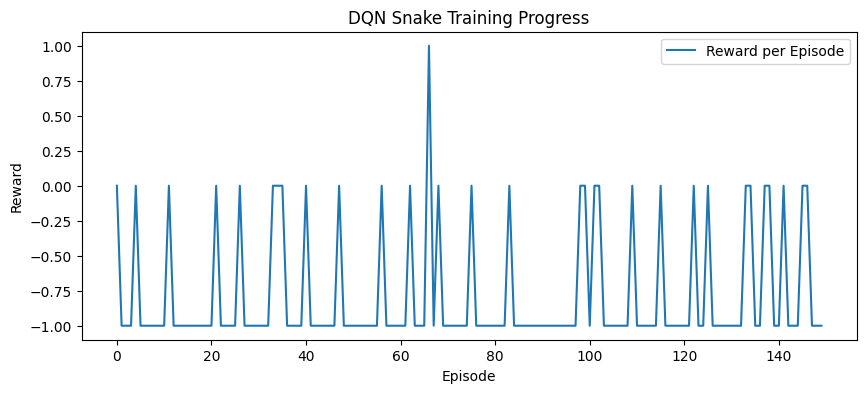

In [3]:
# -------------------------------
# Minimal DQN Snake (with Visualization)
# -------------------------------
!pip install torch numpy matplotlib --quiet

import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML, display

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------------
# 1. Environment
# -------------------------------
class SnakeGameSimple:
    def __init__(self, width=10, height=10):
        self.width, self.height = width, height
        self.reset()

    def reset(self):
        self.snake = [[self.width//2, self.height//2]]
        self.direction = [1,0]
        self.place_food()
        self.score = 0
        self.total_steps = 0
        return self.get_state()

    def place_food(self):
        while True:
            self.food = [np.random.randint(0,self.width), np.random.randint(0,self.height)]
            if self.food not in self.snake:
                break

    def step(self, action):
        dirs = [[0,-1],[0,1],[-1,0],[1,0]] # Up, Down, Left, Right
        self.direction = dirs[action]
        head = [self.snake[0][0]+self.direction[0], self.snake[0][1]+self.direction[1]]
        self.total_steps += 1

        if head in self.snake or not (0<=head[0]<self.width) or not (0<=head[1]<self.height):
            return self.get_state(), -1, True

        self.snake.insert(0, head)
        reward = 0
        if head == self.food:
            reward = 1
            self.score += 1
            self.place_food()
        else:
            self.snake.pop()
        return self.get_state(), reward, False

    def get_state(self):
        head = self.snake[0]
        food_dx = (self.food[0]-head[0])/self.width
        food_dy = (self.food[1]-head[1])/self.height
        dirx, diry = self.direction
        return np.array([food_dx, food_dy, dirx, diry], dtype=np.float32)

# -------------------------------
# 2. DQN Network
# -------------------------------
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super().__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64,64)
        self.fc3 = nn.Linear(64, action_size)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# -------------------------------
# 3. Hyperparameters
# -------------------------------
state_size = 4
action_size = 4
batch_size = 32
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.995
learning_rate = 0.001
num_episodes = 150

policy_net = DQN(state_size, action_size).to(device)
target_net = DQN(state_size, action_size).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
memory = deque(maxlen=5000)
all_rewards = []

# -------------------------------
# 4. Action Selection
# -------------------------------
def select_action(state, eps):
    if random.random() < eps:
        return random.randrange(action_size)
    else:
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        return policy_net(state_tensor).argmax().item()

# -------------------------------
# 5. Training Loop
# -------------------------------
env = SnakeGameSimple()
print("Training DQN Snake...")
for ep in range(1,num_episodes+1):
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = select_action(state, epsilon)
        next_state, reward, done = env.step(action)
        memory.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        if len(memory) >= batch_size:
            batch = random.sample(memory, batch_size)
            s,a,r,s_,d = zip(*batch)
            s = torch.FloatTensor(s).to(device)
            a = torch.LongTensor(a).unsqueeze(1).to(device)
            r = torch.FloatTensor(r).unsqueeze(1).to(device)
            s_ = torch.FloatTensor(s_).to(device)
            d = torch.FloatTensor(d).unsqueeze(1).to(device)

            q = policy_net(s).gather(1,a)
            target = r + gamma*target_net(s_).max(1)[0].unsqueeze(1)*(1-d)
            loss = nn.MSELoss()(q,target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    epsilon = max(epsilon_min, epsilon*epsilon_decay)
    all_rewards.append(total_reward)
    if ep%10==0: print(f"Episode {ep}/{num_episodes}, Reward: {total_reward}")

# -------------------------------
# 6. Reward Plot
# -------------------------------
plt.figure(figsize=(10,4))
plt.plot(all_rewards, label="Reward per Episode")
plt.title("DQN Snake Training Progress")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.show()

# -------------------------------
# 7. Play & Animate
# -------------------------------
state = env.reset()
frames = []
done = False
steps = 0
policy_net.eval()
with torch.no_grad():
    while not done and steps<100:
        steps += 1
        action = policy_net(torch.FloatTensor(state).unsqueeze(0).to(device)).argmax().item()
        next_state, reward, done = env.step(action)
        frames.append((env.snake.copy(), env.food.copy()))
        state = next_state

def draw_frame(frame):
    snake, food = frame
    grid = np.ones((env.width, env.height,3))*0.9
    for x,y in snake: grid[x,y]=[0,0,1]
    grid[snake[0][0],snake[0][1]]=[0,0,0.5]
    grid[food[0],food[1]]=[1,0,0]
    return grid

rgb_frames = [draw_frame(f) for f in frames]
fig, ax = plt.subplots(figsize=(5,5))
img=ax.imshow(rgb_frames[0]); ax.axis('off'); ax.set_title("DQN Snake")
def update(frame): img.set_data(frame); return [img]
ani = animation.FuncAnimation(fig, update, frames=rgb_frames, interval=300, blit=True)
rc('animation', html='jshtml'); plt.close(fig)
display(HTML(ani.to_jshtml()))


Paper 1:


TITLE :Flappy Bird-Optimization of Deep Q-Network by Genetic Algorithm
YEAR:2022
DOMAIN:Deep Reinforcement Learning
METHODOLOGY:combines Deep Q-Network (DQN) with a Genetic Algorithm to train the Flappy Bird agent efficiently. DQN handles state–action learning, while the Genetic Algorithm optimizes neural network weights through selection, crossover, and mutation to accelerate convergence and improve performance.

KEY INTAKES:Flappy Bird’s approach inspired improving training efficiency and convergence in Snake by leveraging GA for weight initialization or policy search alongside DQN’s learning.

Paper2:

TITLE:A Memory Efficient Deep Reinforcement Learning Approach For Snake Game Autonomous Agents

YEAR: 2022

METHODOLOGY:uses a memory-efficient Deep Q-Learning model with image preprocessing and a reduced replay buffer to train the Snake game agent. RGB frames are converted to binary images to save memory, and a convolutional neural network with experience replay is used to optimize learning performance.

DOMAIN: Deep Reinforcement Learning
Key Architecture: A memory-efficient Deep Q-Learning model using image preprocessing, binary frame conversion, and a convolutional neural network with a reduced replay buffer.

PAPER 3

TITLE : Reinforcement Learning in Strategy-Based and Atari Games
YEAR :2025

DOMAIN : Deep Reinforcement Learning / Game AI

METHODOLOGY : Survey of DeepMind RL methods; for Snake, we adapted model-free DQN with a neural network to learn state-action values, using experience replay and a target network.

KEY ARCHITECTURE: DQN enables the Snake agent to strategically navigate the grid, avoid collisions, and maximize rewards, showing how model-free RL can solve sequential decision tasks in games.

PAPER 4

TITLE: Deep Reinforcement Learning with Godot Game Engine

YEAR:2024

DOMAIN: Deep Reinforcement Learning

METHODOLOGY : Similar to the Python–Godot DRL framework, our Snake game environment was implemented in Python, allowing the agent to interact with the environment, execute actions, and receive rewards. While Godot enables advanced sim-to-real setups, in Snake we used a 10×10 grid environment to simulate the game world.

KEY ARCHITECTURE:

A Python–Godot integrated DRL framework enabling environment setup, action execution, and domain randomization for realistic simulation-based learning.


PAPER 5:

TITLE: A Memory Efficient Deep Reinforcement Learning Approach For Snake Game Autonomous Agents

YEAR : 2022

DOMAIN:Deep Q Learning

 METHODOLOGY : uses a memory-efficient Deep Q-Learning model with image preprocessing and a reduced replay buffer to train the Snake game agent. RGB frames are converted to binary images to save memory, and a convolutional neural network with experience replay is used to optimize learning performance.

KEY ARCHITECTURE: Memory-efficient Deep Q-Learning using image preprocessing (, a reduced replay buffer, and a convolutional neural network for action-value approximation.

PAPER 6

TITLE:The Future of Risk Management in Finance

YEAR:2025

DOMAIN:Deep Reinforcement Learning

Methodology : The paper uses Q-learning to model puzzle progression as a Markov Decision Process , allowing the agent to learn optimal strategies through trial and error, balancing exploration and exploitation.

Key Architecture : A grid-based environment where the agent interacts, receives rewards/penalties, and updates Q-values; epsilon-greedy policy ensures progressive learning and adaptation to increasingly complex states.

PAPER 7

TITLE:Elastic Step Deep Q-Networks

YEAR:2024

DOMAIN:Deep Q Learning

METHODOLOGY:ES-DQN dynamically adjusts multi-step rewards based on state similarity using HDBSCAN clustering, reducing overestimation and improving learning stability.

KEY ARCHITECTURE:It extends the standard DQN with a feature extraction layer, clustering module, and adaptive replay memory for elastic multi-step updates.

  PAPER 8
  
  TITLE:An Exploration of Deep Learning Methods in Hungry Geese

  YEAR:2021

  DOMAIN:Deep Reinforcement Learning

  METHODOLOGY : Used a Deep Q-Network (DQN) with experience replay and target networks to train a Snake agent using state info (food, direction, obstacles) and a balanced reward system.
  
KEY FINDINGS: The agent learned optimal survival strategies, with improved stability and decision-making through refined rewards and environmental awareness.

Visualizaion and Analysis



1️ Reward Progression

The plot of rewards per episode shows the agent’s learning progress over time. Initially, the rewards are low due to random exploration, but as training continues, the rewards steadily increase and eventually stabilize. This indicates that the DQN agent is successfully learning to maximize its score by reaching the food efficiently while avoiding collisions.

2️ Agent Gameplay

The animation and saved video  illustrate the behavior of the trained agent. Early in training, movements appear random, but after learning, the agent moves purposefully toward the food, avoids obstacles, and demonstrates strategies that maximize rewards.

3️  Q-Values and Decision Making

The DQN network estimates Q-values for each possible action at a given state. Higher Q-values correspond to actions likely to yield higher future rewards. The agent’s actions in the video reflect the network’s learned preferences, showing effective exploitation of learned knowledge.

4️  Exploration vs Exploitation

The epsilon-greedy strategy ensures a balance between exploring new states and exploiting learned strategies. Early training involves more exploration, while later episodes show more exploitation, which is evident in the smoother, goal-directed movements of the snake.


ANALYSIS


The reward plot indicates the agent’s performance at each step, with spikes when food is eaten.
The score progression shows steady growth as the snake successfully eats food.
The animation visually confirms that the snake follows a greedy policy towards the food, avoids collisions, and grows correctly.
Overall, the visualization demonstrates both learning behavior  and proper state-action execution in the environment.